## Introduction

#### Machine Learning model to forecast the demand of the car rentals on an hourly basis.

### Import the necessary packages.

In [ ]:
!pip install -q klib

In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns # visualization
from matplotlib import pyplot as plt # visualization
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import re
import klib

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


### Import train and test dataset

In [4]:
train=pd.read_csv("/content/gdrive/MyDrive/AV_job-a-thon-april-2022/train_E1GspfA.csv")
test=pd.read_csv("/content/gdrive/MyDrive/AV_job-a-thon-april-2022/test_6QvDdzb.csv")

### Structure of the train and test dataset.

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18247 entries, 0 to 18246
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   date    18247 non-null  object
 1   hour    18247 non-null  int64 
 2   demand  18247 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 427.8+ KB


#### The above information shows that there are 18247 data entries and 3 columns.

In [ ]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7650 entries, 0 to 7649
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   date    7650 non-null   object
 1   hour    7650 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 119.7+ KB


#### The above information shows that there are 7650 data entries and 2 columns.

#### Let's see is there any missing values in train and test dataset by column wise.

In [ ]:
train.isnull().sum()

date      0
hour      0
demand    0
dtype: int64

#### The above information shows that there are no missing values in the train dataset.

In [ ]:
test.isnull().sum()

date    0
hour    0
dtype: int64

#### The above information shows that there are no missing values in the train dataset.

#### Let's see the glimpse of train dataset

In [ ]:
train.head()

,date,hour,demand
0,2018-08-18,9,91
1,2018-08-18,10,21
2,2018-08-18,13,23
3,2018-08-18,14,104
4,2018-08-18,15,81


### Let's create a function for box plot.

In [5]:
def box_plot(df,col,rot=None):
  _=plt.figure(figsize=(8,6))
  _=sns.boxplot(y=df[col])
  _=plt.title(col.capitalize()+" Distribution",fontsize=25)
  _=plt.ylabel(col,fontsize=20,rotation=rot)
  _=plt.yticks(fontsize=14)


### Let's see the demand column distribution.

Large dataset detected, using 10000 random samples for the plots. Summary statistics are still based on the entire dataset.


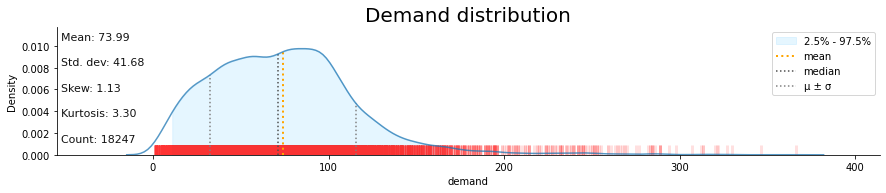

In [ ]:
klib.dist_plot(train['demand']);
plt.title("demand distribution".capitalize(),fontsize=20);

In [ ]:
train['demand'].describe()

count    18247.000000
mean        73.991451
std         41.678988
min          1.000000
25%         43.000000
50%         71.000000
75%         98.000000
max        379.000000
Name: demand, dtype: float64

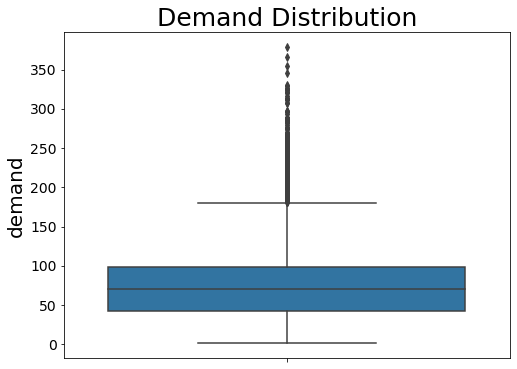

In [ ]:
box_plot(train,'demand',rot=90)

#### The above histogram explains that demand column is postively skewed. 

### The demand ranges from 1 to 379.

### The average demand value is 73.99.

#### The boxplot explains that there are outliers above the third quartile.

#### Let's do some feature engineering on date column.

In [8]:
def pre_process(df):
  df['date_time']=pd.to_datetime((df["date"] +" "+ df['hour'].astype('str')),format="%Y-%m-%d  %H") #convert to date-time format
  df['day']=df['date_time'].dt.day #extract day from the date
  df['day_label']=df['date_time'].dt.day_name() #extract the day name from the date
  df['day_number']=df['date_time'].dt.dayofweek #extract the day number from the date
  df['month_number']=df['date_time'].dt.month #extract month number from the date
  df['month_label']=df['date_time'].dt.strftime('%b') #extract the month name from the date
  df['year_quarter']=df['date_time'].dt.quarter #extract the quarter of the year
  df['week_of_year']=df['date_time'].dt.week #extract week of the year from date
  df['year']= df['date_time'].dt.year #extract year
  df['dayofmonth'] = df['date_time'].dt.daysinmonth #extract the day of the month
  df['dayofyear'] = df['date_time'].dt.day_of_year #extract day of the year
  df['weekday']=df['date_time'].dt.day_name().isin(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']).astype('int') #create weekday column
  df['weekend']=df['date_time'].dt.day_name().isin(['Saturday', 'Sunday']).astype('int') #create weekend column
  df['month_start']=df['date_time'].dt.is_month_start.astype('int') #create month start
  df['month_end']=df['date_time'].dt.is_month_end.astype('int') #create month end
  df['quarter_start']=df['date_time'].dt.is_quarter_start.astype('int') #create quarter start
  df['quarter_end']=df['date_time'].dt.is_quarter_end.astype('int') #create quarter end
  df['year_start']=df['date_time'].dt.is_year_start.astype('int') #create year start
  df['year_end']=df['date_time'].dt.is_year_end.astype('int') #create year end
  df['hour']=df['date_time'].dt.hour
 
  #function to convert month to seasons
  def month2seasons(x):
    season=""
    if x in [1, 2]:
        season = 'winter'
    elif x in [3, 4, 5]:
        season = 'summer'
    elif x in [6,7,8,9]:
        season = 'monsoon'
    elif x in [10,11,12]:
        season = 'post-monsoon'
    return season

 
  df['seasons']=df['month_number'].apply(month2seasons)

  def hours2timing(x):
    if x in range(20,23):
        timing = 'Night'
    elif x in range(5,12):
        timing = 'Morning'
    elif x in range(12, 16):
        timing = 'Afternoon'
    elif x in range(16, 20):
        timing = 'Evening'
    elif x in [23,0,1,2,3,4]:
        timing = 'Midnight'    
    else:
        timing = 'X'
    return timing



  df['timings']=df['hour'].apply(hours2timing) 

  return df

In [9]:
train=pre_process(train)

### Let's see how the demand for car rentals changes over the year.

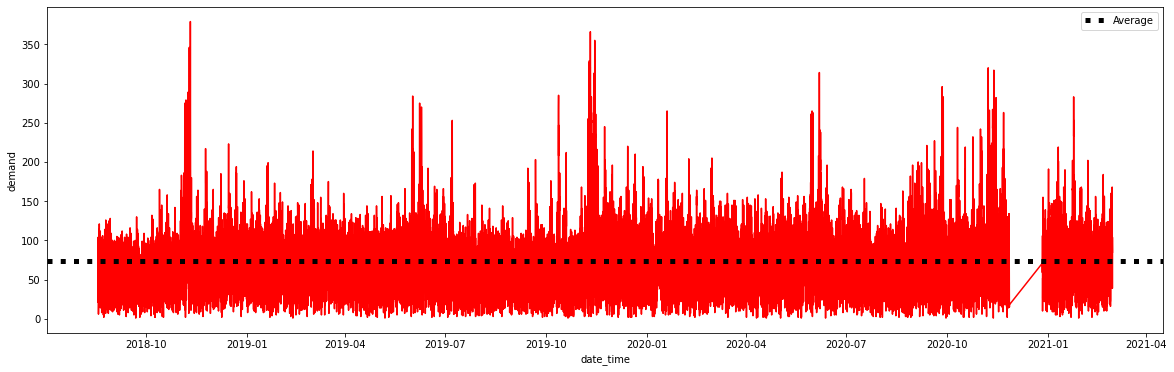

In [ ]:
plt.figure(figsize=(20,6))
yr=sns.lineplot(x=train['date_time'],y=train['demand'],color="Red")
yr.axhline(train.groupby('date_time')['demand'].agg({'mean'}).mean()[0],
          ls=":",color="Black",lw=5,label='Average');
plt.legend();          

### Let's see how the demand for car rentals changes over 12 months.

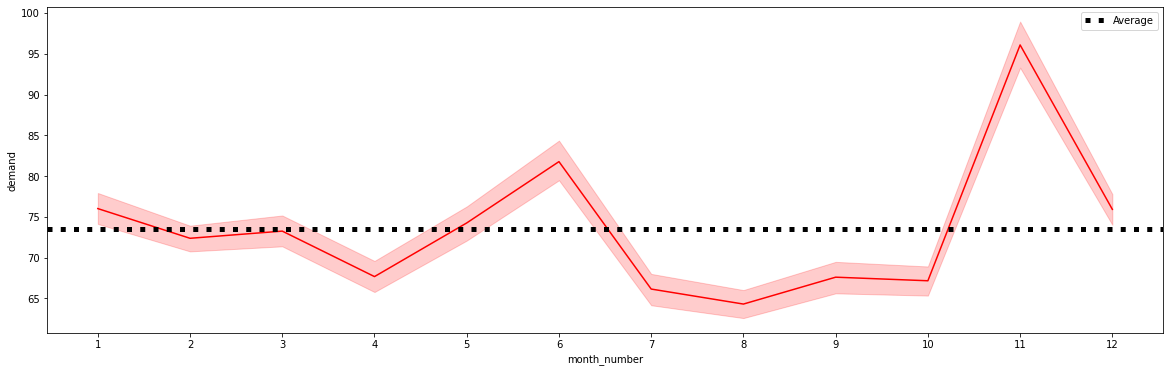

In [11]:
plt.figure(figsize=(20,6))
yr=sns.lineplot(x=train['month_number'],y=train['demand'],color="Red")
yr.axhline(train.groupby('month_number')['demand'].agg({'mean'}).mean()[0],
          ls=":",color="Black",lw=5,label='Average');
plt.legend(); 
plt.xticks(range(1,13));         

#### The above plot explains that the demand for car rentals is high in the month of january, may, june, december(higher than the 12 months average).

####  The demand car rentals is low in the month of february, march, july, august, septembar, and october(lower than the 12-month average).


### Let's see how the demand for car rentals changes the 52 weeks.

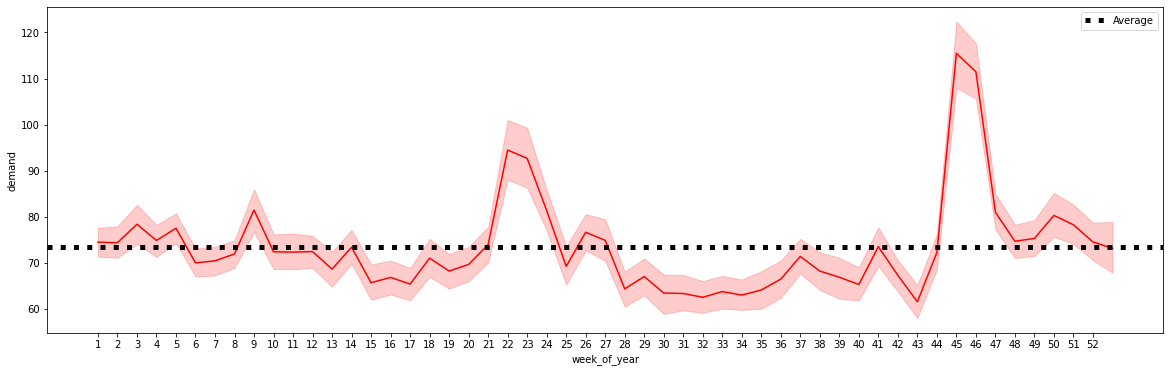

In [12]:
plt.figure(figsize=(20,6))
yr=sns.lineplot(x=train['week_of_year'],y=train['demand'],color="Red")
yr.axhline(train.groupby('week_of_year')['demand'].agg({'mean'}).mean()[0],
          ls=":",color="Black",lw=5,label='Average');
plt.legend();  
plt.xticks(range(1,53));         

#### The above plot explains that the demand for car rentals is high in the week 1 to 5, 9, 21 to 24, 26, 27, after the week 44(higher than the 52-week average).

####  The demand for car rentals is low in the week 6 to 8, 10 to 21, 25, after the week of 27(higher than the 52-week average).


### Let's see how the demand for car rentals changes over the 24 hours of the day.

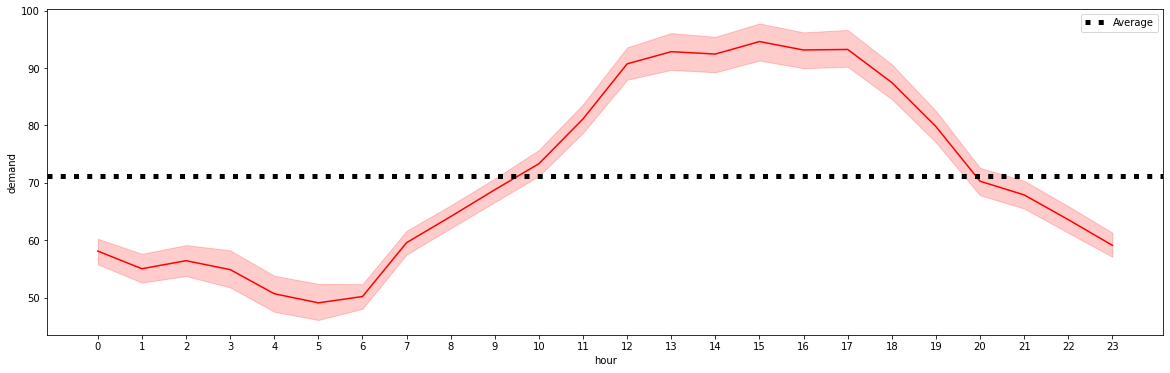

In [ ]:
plt.figure(figsize=(20,6))
yr=sns.lineplot(x=train['hour'],y=train['demand'],color="Red",
                )
yr.axhline(train.groupby('hour')['demand'].agg({'mean'}).mean()[0],
          ls=":",color="Black",lw=5,label='Average');
plt.legend();
plt.xticks(range(0,24));          

#### The above plot explains that the demand for car rental gradually increased from hour 6 to 5. after hour 5 the demand decreased gradually.

#### The demand is partially constant at the hours 12 to 5.

### Let's see how the demand for car rental changes over time with different climate seasons.

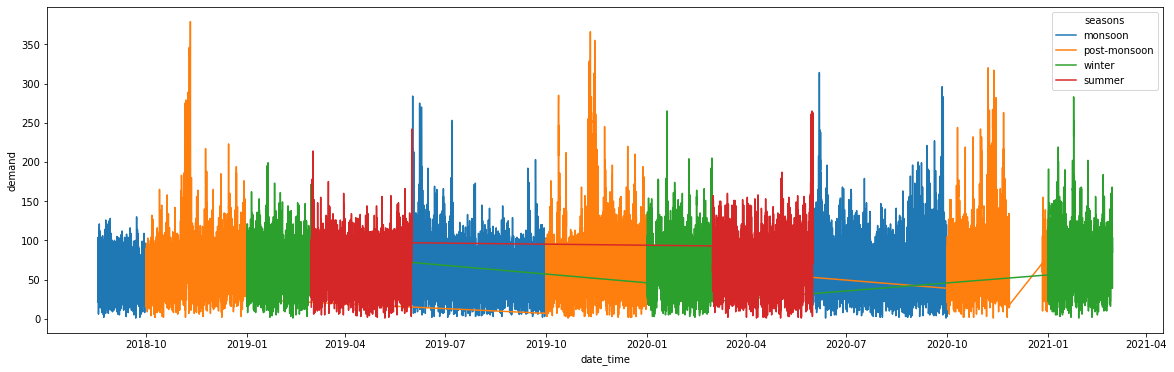

In [18]:
plt.figure(figsize=(20,6))
_=sns.lineplot(x=train['date_time'],y=train['demand'],hue=train['seasons'])       

#### The above plot explains that the demand for car rental is high in the monsoon and post-monsoon seasons.

### Let's see how the demand for car rental changes over the years with different timings of the day.

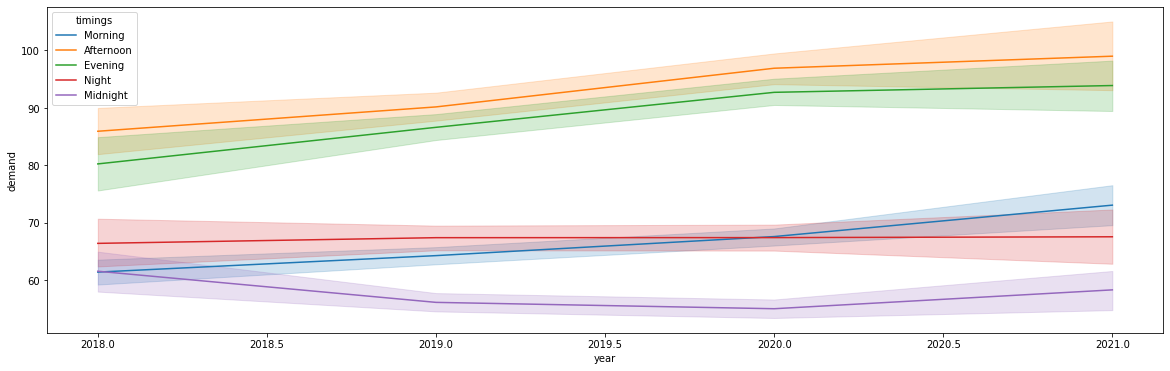

In [20]:
plt.figure(figsize=(20,6))
_=sns.lineplot(x=train['year'],y=train['demand'],hue=train['timings'])       

#### The above plot explains that over the years the demand for car rental is high in the afternoon and evening time.

### Let's use a grid plot and see how the demand changed over the 52 weeks of the year based on different timings of the day.

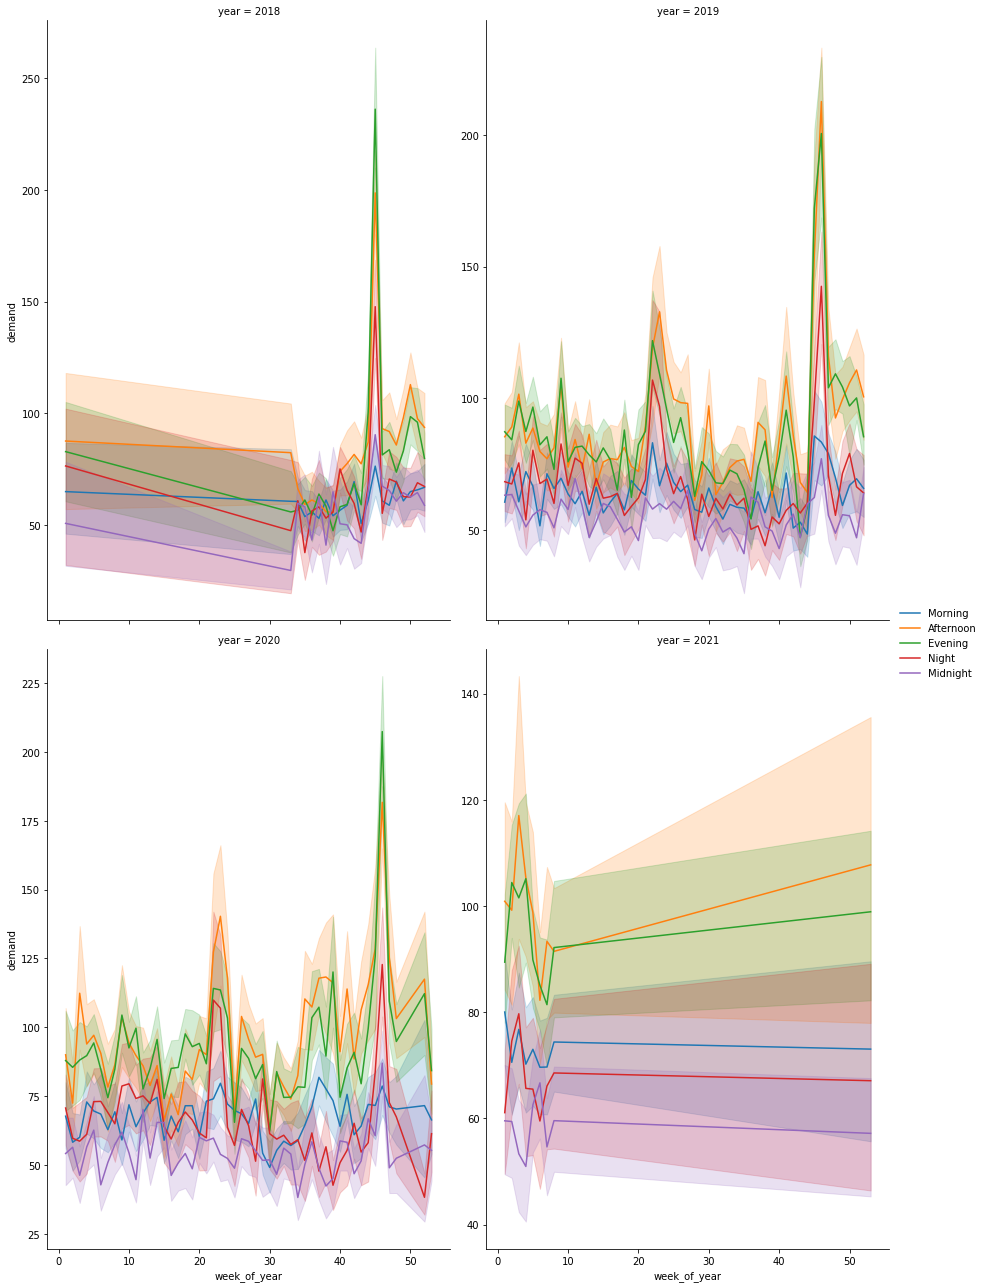

In [26]:
g = sns.FacetGrid(train, col="year",sharey=False,col_wrap=2,height=9,aspect=.7)
g.map_dataframe(sns.lineplot, x="week_of_year", y="demand",hue=train['timings'])
g.add_legend()

#### The above plot explains that each year the demand show various pattern at different timing of the day.

### Let's use acf and pacf and see how values are correlated with previous value. 

In [28]:
import statsmodels.api as sm

### ACF function

In [29]:
def acf_plot(df,date,valcol,lag):
  plt.rc("figure", figsize=(16,8))
  x=train[[date,valcol]]
  x.set_index(date,inplace=True)
  lag_acf = sm.graphics.tsa.plot_acf(x[valcol], lags=lag)
  plt.title(valcol)  



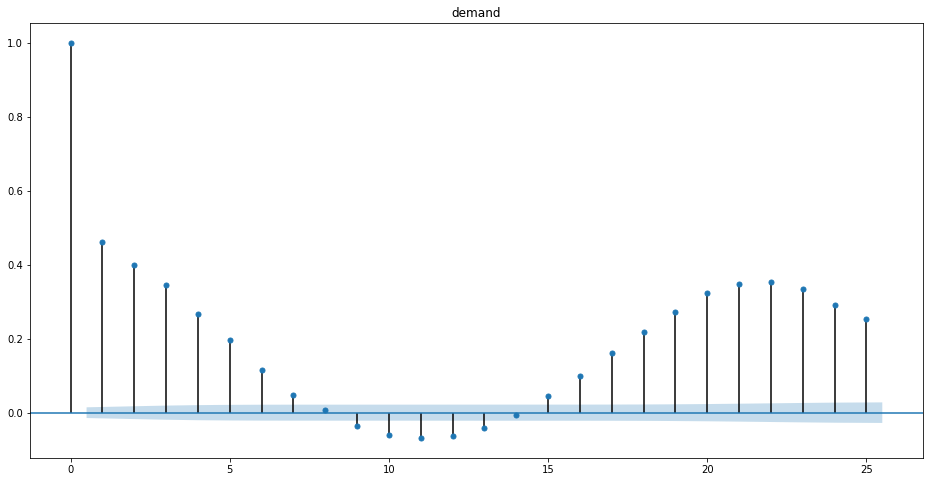

In [30]:
acf_plot(train,'date_time','demand',lag=25)

#### The acf plot expains that at lag of 7 the current value is higly correlated

### PACF function

In [34]:
def pacf_plot(df,date,valcol,lag):
  plt.rc("figure", figsize=(16,8))
  x=train[[date,valcol]]
  x.set_index(date,inplace=True)
  lag_pacf = sm.graphics.tsa.plot_pacf(x[valcol], lags=lag)
  plt.title(valcol)   

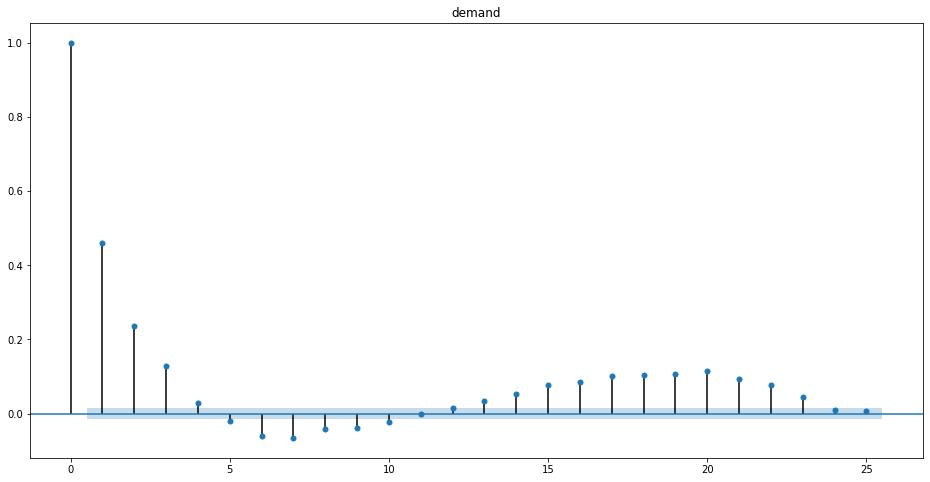

In [35]:
pacf_plot(train,'date_time','demand',lag=25)

#### The pacf plot expains that at lag of 4 the current value is higly correlated

In [31]:
from statsmodels.tsa.stattools import adfuller

### ADF test function

In [32]:
def adf_test(df,date,valcol):
  x=df[[date,valcol]]
  x.set_index(date,inplace=True)
  print("Observations of Dickey-fuller test")
  dftest = adfuller(x[valcol],autolag='AIC')
  dfoutput=pd.Series(dftest[0:4],index=['Test Statistic','p-value','#lags used','number of observations used'])
  for key,value in dftest[4].items():
      dfoutput['critical value (%s)'%key]= value
  print(dfoutput)

In [ ]:
adf_test(train,'date_time','demand')

Observations of Dickey-fuller test
Test Statistic                -1.254362e+01
p-value                        2.285775e-23
#lags used                     2.200000e+01
number of observations used    1.822400e+04
critical value (1%)           -3.430709e+00
critical value (5%)           -2.861699e+00
critical value (10%)          -2.566854e+00
dtype: float64


#### The above test explains that the p-value is <0.05 so reject the null hypothesis(non-stationary) and conclude data is stationary.